### Import libraries

In [40]:
import pandas as pd
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

### Download the data

In [41]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

trainset = datasets.FashionMNIST('./', download = True , train = True, transform = transform)
trainloader = DataLoader(trainset, batch_size = 64, shuffle = True)

testset = datasets.FashionMNIST('./', download = True, train = False, transform = transform)
testloader = DataLoader(testset, batch_size = 64, shuffle = True)

### Helper Function to visualize MNIST and FashionMNSIT dataset

In [42]:
import matplotlib.pyplot as plt
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

### Visualizing the dataset

In [43]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

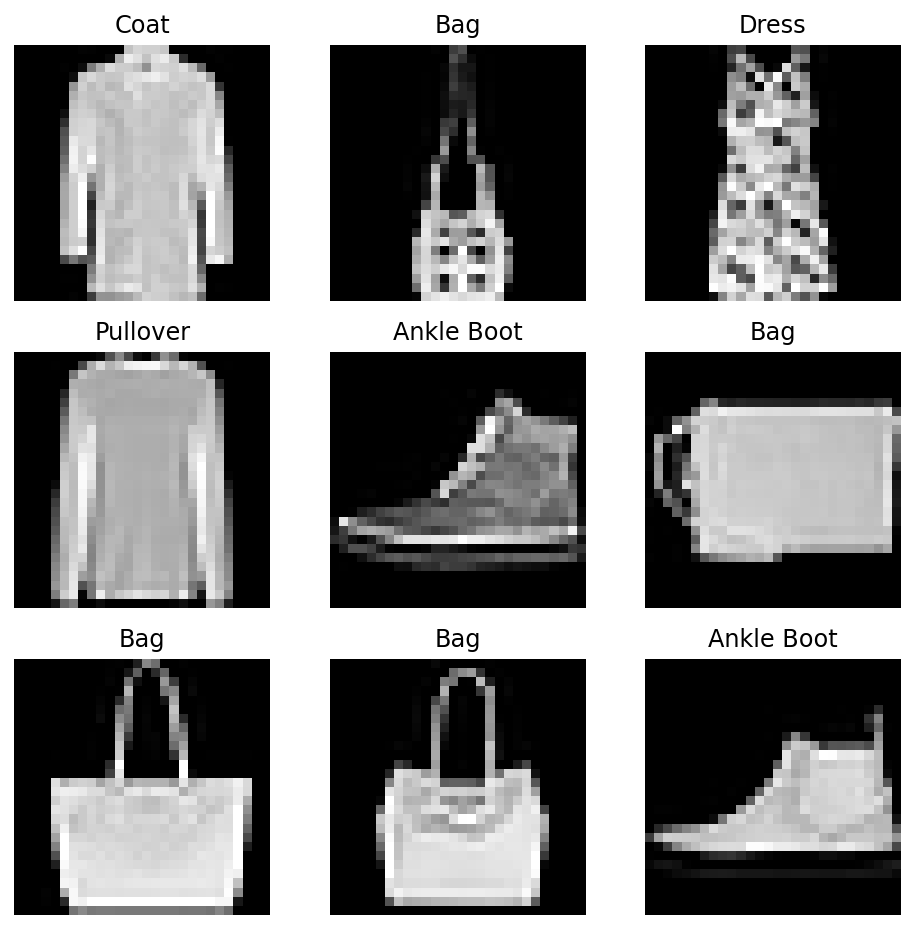

In [44]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Define the model

In [45]:
from torch import nn, optim
import torch.nn.functional as F

In [46]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, X):
        X = X.view(X.shape[0], -1)
        
        X = self.dropout(F.relu(self.fc1(X)))
        X = self.dropout(F.relu(self.fc2(X)))
        X = self.dropout(F.relu(self.fc3(X)))
        
        X = F.log_softmax(self.fc4(X), dim=1)

        return X

In [47]:
Net = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(Net.parameters() ,lr = 0.001)

### Training the model

In [48]:
epochs = 5
train_losses, test_losses = [], []

for e in range(epochs):
    train_loss = 0
    Net.train()
    for X_train, y_train in trainloader:        
        optimizer.zero_grad()
        
        log_ps = Net(X_train)
        loss = criterion(log_ps, y_train)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            Net.eval()
            for X_test, y_test in testloader:                
                log_ps = Net(X_test)
                
                test_loss += criterion(log_ps, y_test)
                ps = torch.exp(log_ps)
                
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == y_test.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(train_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/5..  Training Loss: 0.653..  Test Loss: 0.473..  Test Accuracy: 0.824
Epoch: 2/5..  Training Loss: 0.478..  Test Loss: 0.448..  Test Accuracy: 0.839
Epoch: 3/5..  Training Loss: 0.432..  Test Loss: 0.407..  Test Accuracy: 0.850
Epoch: 4/5..  Training Loss: 0.408..  Test Loss: 0.378..  Test Accuracy: 0.863
Epoch: 5/5..  Training Loss: 0.391..  Test Loss: 0.375..  Test Accuracy: 0.863


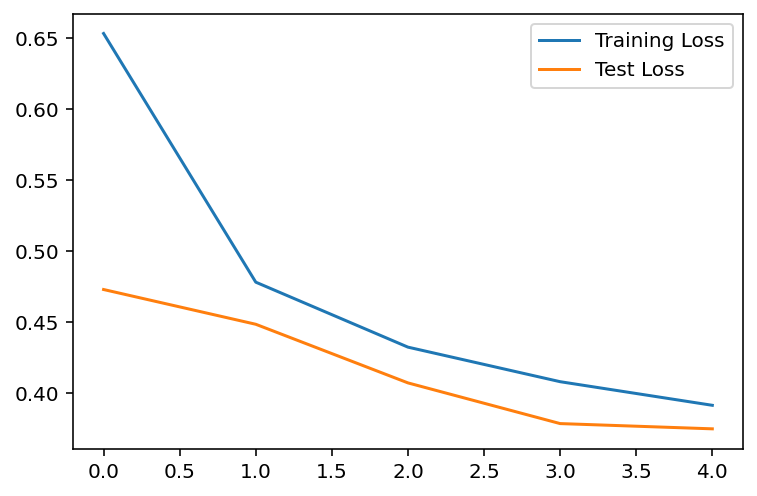

In [49]:
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()

### Predicting on Test Set

Sneaker


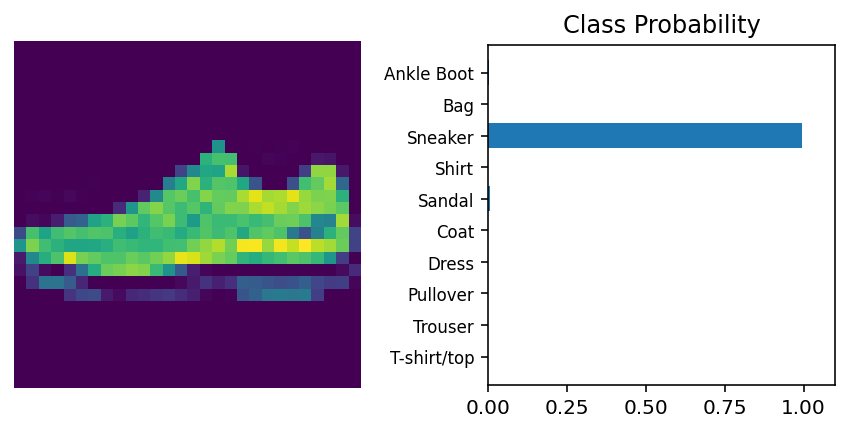

In [54]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper

dataiter = iter(testloader)
images, labels = dataiter.next()
print(labels_map[labels[1].item()])
img = images[1]

ps = torch.exp(Net(img))

view_classify(img, ps, version='Fashion')

In [71]:
X_test = []
y_test = []
for x,y in testset:
    X_test.append(x)
    y_test.append(y)

In [72]:
X_test = torch.cat(X_test, dim = 0)

In [73]:
y_test = torch.tensor(y_test)

## Accuracy of the model

In [74]:
with torch.no_grad():
    ypred = Net(X_test)
    ps = torch.exp(ypred)
    top_p, top_class = ps.topk(1,dim=1)
    equals = top_class == y_test.view(*top_class.shape)
    accuracy = torch.mean(equals.type(torch.FloatTensor))
print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.863


### Saving the model

In [ ]:
print("Our model: \n\n", Net, '\n')
print("The state dict keys: \n\n", Net.state_dict().keys())

Our model: 

 Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [ ]:
torch.save(Net.state_dict(), 'checkpoint.pth')

# Load back the saved weights and bias
# state_dict = torch.load('checkpoint.pth')
# new_model = Classifier()
# new_model.load_state_dict(state_dict)